# Some examples of iterative local methods

The scripts below compare several different types of gradient-based iterative methods on a smooth 2-D test function of two variables with a single global minimum. The methods compared are:

* Gradient descent
* Nesterov's accelerated method
* BFGS (a Quasi-Newton method)
* Newton's method

The methods are ordered by increasing computational complexity but also increasing speed, which demonstrates the trade-off for each method. Newton's method is extremely fast, but also costly from a memory and storage standpoint. The larger the dimension of the underlying space, the more expensive or difficult it becomes to store and manipulate gradients and Hessians. So when the space is larger, we tend to favor simpler methods such as gradient descent. The test function we're using is:

\begin{align}
f(x,y)=e^{−(x−3)/2}+e^{(x+4y)/10}+e^{(x−4y)/10}
\end{align}

This function has a global minimum at about (4.03,0).

## Some helper functions


In [1]:
using LinearAlgebra

# the function of interest
function f(x)
    return exp(-(x[1]-3)/2) + exp((4x[2] + x[1])/10) + exp((-4x[2] + x[1])/10)
end

# the optimal value of x:
xopt = [-(5/6)*(-3 + 2*log(2) - 2*log(5)); 0]
fopt = f(xopt)

# the gradient of the function f(x) at x
function g(x)
    g1 = -1/2*exp(-(x[1]-3)/2) + 1/10*exp((x[1]-4x[2])/10) + 1/10*exp((x[1]+4x[2])/10)
    g2 = -2/5*exp((x[1]-4x[2])/10) + 2/5*exp((x[1]+4x[2])/10)
    return [g1; g2]
end

# the Hessian of the function f(x) at x
function h(x)
    h11 = 1/4*exp(-(x[1]-3)/2) + 1/100*exp((x[1]-4x[2])/10) + 1/100*exp((x[1]+4x[2])/10)
    h12 = -2/50*exp((x[1]-4x[2])/10) + 2/50*exp((x[1]+4x[2])/10)
    h22 = 4/25*exp((x[1]-4x[2])/10) + 4/25*exp((x[1]+4x[2])/10)
    return [h11 h12; h12 h22]
end

M = 400          # number of iterations we'll do
xstart = [8;-3]   # starting point
;

### Gradient descent

In [2]:
# Gradient descent
xg = zeros(2,M)
xg[:,1] = xstart
L = norm(h(xstart))  # heuristic for choosing Lipschitz constant (for stepsize)
for k = 1:M-1
    d = -g(xg[:,k])  # descent direction is the negative gradient
    t = 1/L          # constant stepsize (can also do a line search here)
    xg[:,k+1] = xg[:,k] + t*d
end

### Nesterov's Method

In [3]:
# Nesterov's accelerated method (variant with constant coefficients)
xh = zeros(2,M)
y = xstart
xh[:,1] = xstart
L = norm(h(xstart))        # heuristic for choosing Lipschitz constant
μ = L/cond(h(xstart))      # heuristic for choosing strong convexity parameter
β = (sqrt(L)-sqrt(μ))/(sqrt(L)+sqrt(μ))   # heuristic for choosing momentum parameter
for k = 1:M-1
    xh[:,k+1] = y - 1/L*g(y)
    y = xh[:,k+1] + β*(xh[:,k+1] - xh[:,k])
end

### BFGS

In [4]:
# BFGS methdod
xb = zeros(2,M)
yb = zeros(2,M)
Bb = I(2)
xb[:,1] = xstart
gk = g(xb[:,1])
for k = 1:M-1
    gkp = gk
    p = -Bb\gk
    s = p         # can also do a line search here instead
    xb[:,k+1] = xb[:,k] + s
    gk = g(xb[:,k+1])
    y = gk - gkp
    Bb = Bb + (y*y')/dot(y,s) - ((Bb*s)*(Bb*s)')/dot(s,Bb*s)
end


### Newton's method

In [6]:
# Newton's method
xn = zeros(2,M)
xn[:,1] = xstart
for k = 1:M-1
    xn[:,k+1] = xn[:,k] - h(xn[:,k])\g(xn[:,k])
end
;

## Plot the behavior of each algorithm

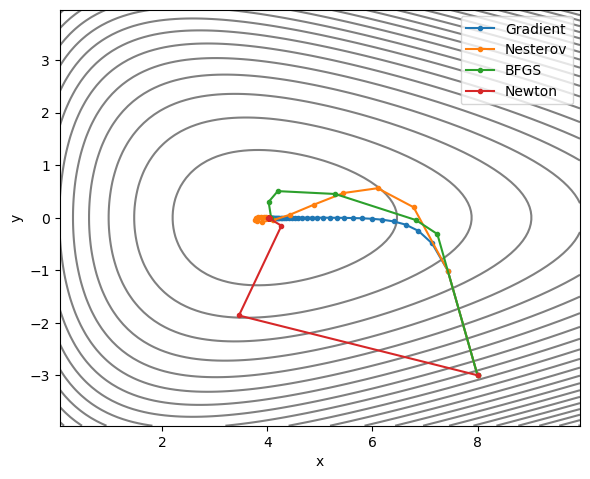

In [9]:
using PyPlot
pygui(false)
figure(figsize=(6,5))


# compute contours of the original function
N = 100
xv = range(0,stop=10,length=N)
yv = range(-4,stop=4,length=N)
fv = zeros(N,N)

for (i,x) in enumerate(xv)
    for (j,y) in enumerate(yv)
        fv[j,i] = f([x;y])
    end
end

contour( fv, origin="lower", extent=(0,10,-4,4), 25, colors="gray" )
plot( xg[1,:], xg[2,:], ".-")
plot( xh[1,:], xh[2,:], ".-")
plot( xb[1,:], xb[2,:], ".-")
plot( xn[1,:], xn[2,:], ".-")
legend(["Gradient", "Nesterov", "BFGS", "Newton"])

axis("image"); xlabel("x"); ylabel("y")
tight_layout();


## A "zoomed in" plot

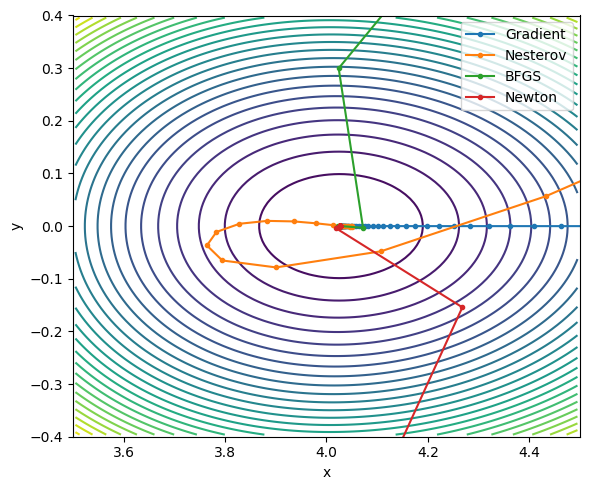

In [10]:
# Again, but more zoomed in this time.

using PyPlot
pygui(false)
figure(figsize=(6,5))


# compute contours of the original function
N = 100
xv = range(3.5,stop=4.5,length=N)
yv = range(-.4,stop=.4,length=N)
fv = zeros(N,N)

for (i,x) in enumerate(xv)
    for (j,y) in enumerate(yv)
        fv[j,i] = f([x;y])
    end
end

contour( fv, origin="lower", extent=(3.5,4.5,-.4,.4), 25 )
plot( xg[1,:], xg[2,:], ".-")
plot( xh[1,:], xh[2,:], ".-")
plot( xb[1,:], xb[2,:], ".-")
plot( xn[1,:], xn[2,:], ".-")
legend(["Gradient", "Nesterov", "BFGS", "Newton"])
axis([3.5,4.5,-.4,.4])
xlabel("x"); ylabel("y")
tight_layout();


## Plot convergence rates

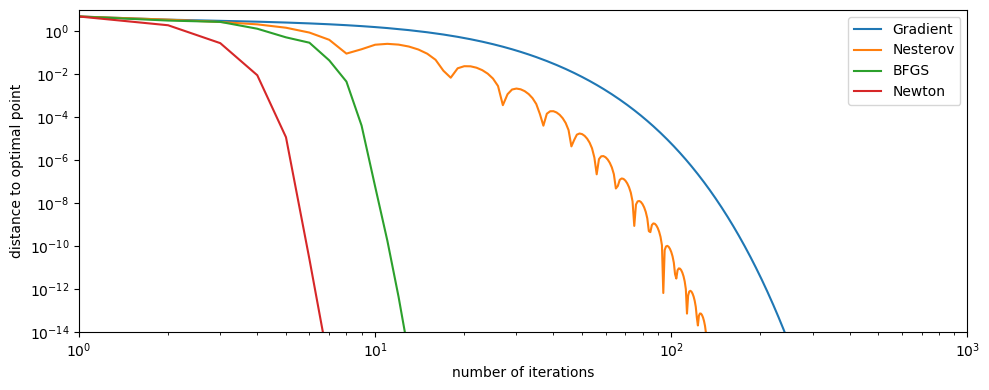

In [11]:
dist_grad = sqrt.(sum(( xg - xopt*ones(1,M)).^2,dims=1)');
dist_nest = sqrt.(sum(( xh .- xopt.*ones(1,M)).^2,dims=1)');
dist_bfgs = sqrt.(sum(( xb .- xopt.*ones(1,M)).^2,dims=1)');
dist_newt = sqrt.(sum(( xn .- xopt.*ones(1,M)).^2,dims=1)');

figure(figsize=(10,4))
loglog(1:M, dist_grad)
loglog(1:M, dist_nest)
loglog(1:M, dist_bfgs)
loglog(1:M, dist_newt)
legend(["Gradient", "Nesterov", "BFGS", "Newton"])
axis([1,1e3,1e-14,1e1])
xlabel("number of iterations"); ylabel("distance to optimal point")
tight_layout();
;

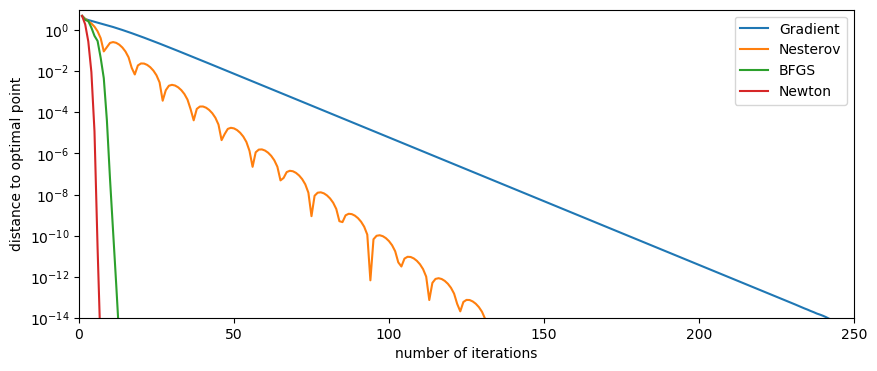

In [12]:
figure(figsize=(10,4))
semilogy(1:M, dist_grad)
semilogy(1:M, dist_nest)
semilogy(1:M, dist_bfgs)
semilogy(1:M, dist_newt)
legend(["Gradient", "Nesterov", "BFGS", "Newton"])
axis([0,250,1e-14,1e1])
xlabel("number of iterations"); ylabel("distance to optimal point")
;